In [44]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision import tv_tensors
from torchvision.io import decode_image
import torchvision.models as models
from torchvision.ops import generalized_box_iou_loss
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from tqdm.auto import tqdm
import requests
import zipfile
import pathlib
from pathlib import Path
import shutil
import os
import pandas as pd
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold
from typing import Tuple, Dict, List
import sys
from timeit import default_timer as timer

# %load_ext autoreload
# %autoreload 1
# %aimport CarImageClass
import CarImageClass

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'desktop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"D:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

In [45]:
train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=None)

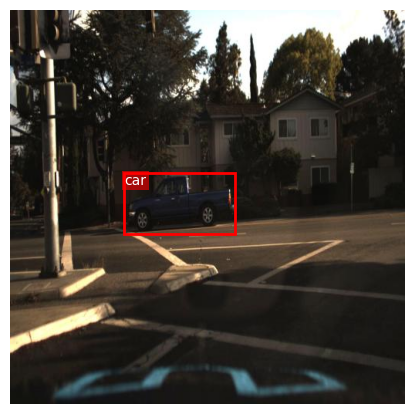

In [46]:
train_data.show_with_box(index=0, color='r', label=True)

In [47]:
# Create transform (no data augmentation)
data_transform = v2.Compose([
    v2.Resize((128, 128)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
])

In [48]:
# 1. Load and transform data
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=False),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=transforms)

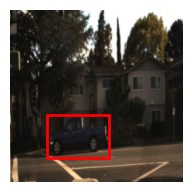

In [49]:
train_data.show_with_box(index=0, color='r', label=False)

In [50]:
class SingleBoxRegressor(nn.Module):
    def __init__(self, pixel_count: int):
        """
        The image is transformed from 512 x 512 to pixel_count x pixel_count.
        """
        super().__init__()
        self.pixel_count = pixel_count
        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        in_f = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.backbone = backbone
        self.head = nn.Sequential(
            nn.Linear(in_f, pixel_count), nn.ReLU(inplace=True),
            nn.Linear(pixel_count, 4),    # a,b,c,d -> x1,y1,dx,dy
        )

    def forward(self, x):
        t = self.head(self.backbone(x))
        a, b, c, d = t.unbind(dim=1)

        x1 = a.sigmoid() * self.pixel_count               # in (0,pixel_count)
        y1 = b.sigmoid() * self.pixel_count
        dx = c.sigmoid() * (self.pixel_count - x1)        # in (0, pixel_count - x1]
        dy = d.sigmoid() * (self.pixel_count - y1)

        x2 = x1 + dx                                      # x2 ∈ [x1,pixel_count)
        y2 = y1 + dy
        return torch.stack([x1, y1, x2, y2], dim=1)

In [51]:
torch.manual_seed(42)
model_0 = SingleBoxRegressor(pixel_count=224).to(device)

model_0

SingleBoxRegressor(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [52]:
# random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pix_count = 224

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),                                 # uint8 -> Tensor[C,H,W]
    v2.ToDtype(torch.float32, scale=True),        # to float in [0,1]
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((pix_count, pix_count)),                        # pick a fixed size for batching
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((pix_count, pix_count)),
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# training/testing data
train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=train_tfms)
test_data = CarImageClass.ImageClass(targ_dir=test_path_oo, transform=test_tfms)


BATCH_SIZE = 16
# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              #num_workers=NUM_WORKERS,
                              )

test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False, 
                             #num_workers=NUM_WORKERS,
                             )

In [53]:
train_data[0]

(Image([[[-1.5382, -1.7649, -1.8028,  ...,  2.2489,  2.1042,  2.0061],
         [-1.8725, -1.9549, -2.0085,  ...,  2.2489,  2.2471,  2.2475],
         [-1.9959, -1.9820, -2.0086,  ...,  2.2489,  2.2489,  2.2489],
         ...,
         [-2.0903, -2.0903, -2.0903,  ..., -1.8942, -1.8858, -1.8526],
         [-2.0903, -2.0903, -2.0903,  ..., -1.8543, -1.8718, -1.8522],
         [-2.0903, -2.0903, -2.0903,  ..., -1.8235, -1.8594, -1.8589]],
 
        [[-1.3267, -1.5391, -1.5405,  ...,  2.4286,  2.3160,  2.2474],
         [-1.6602, -1.7303, -1.7481,  ...,  2.4286,  2.4286,  2.4286],
         [-1.7663, -1.7489, -1.7411,  ...,  2.4286,  2.4286,  2.4286],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -1.7292, -1.7206, -1.6866],
         [-2.0357, -2.0357, -2.0357,  ..., -1.6884, -1.7063, -1.6863],
         [-2.0357, -2.0357, -2.0357,  ..., -1.6569, -1.6936, -1.6931]],
 
        [[-1.5423, -1.6827, -1.6871,  ...,  2.6396,  2.3984,  2.2766],
         [-1.7929, -1.8040, -1.8037,  ..., 

In [54]:
image_batch, target_batch = next(iter(train_dataloader))

m0test = model_0(image_batch.to(device))

m0test[0]

tensor([111.0213, 107.5219, 162.9198, 158.9617], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [55]:
float(m0test[0][3])

158.961669921875

In [56]:
target_batch['boxes']

tensor([[[ 42.4375, 118.1250,  51.1875, 123.8125]],

        [[105.0000, 111.5625, 123.8125, 123.8125]],

        [[ 55.1250,  99.3125,  84.4375, 139.1250]],

        [[ 29.7500,  97.5625,  66.9375, 139.1250]],

        [[142.6250,   0.0000, 223.5625, 185.5000]],

        [[ 65.6250, 102.3750,  87.9375, 129.0625]],

        [[ 73.9375, 123.8125,  81.8125, 133.4375]],

        [[115.9375, 120.7500, 124.2500, 131.2500]],

        [[  0.8750, 128.6250,  38.5000, 161.4375]],

        [[169.7500,  97.5625, 177.1875, 110.6875]],

        [[ 89.6875, 104.1250, 101.5000, 121.1875]],

        [[112.8750, 116.3750, 126.0000, 133.8750]],

        [[ 89.6875, 100.1875, 121.1875, 145.6875]],

        [[200.3750,  94.5000, 224.0000, 156.1875]],

        [[ 66.9375, 102.3750,  87.5000, 128.1875]],

        [[ 11.3750,  74.8125, 118.1250, 143.5000]]])

In [57]:
rand_index = np.random.randint(0, BATCH_SIZE)

image_index = target_batch['image_id'][rand_index]

image_index

tensor([332])

In [58]:
target_batch['boxes'][rand_index]

tensor([[ 73.9375, 123.8125,  81.8125, 133.4375]])

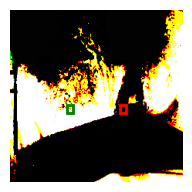

In [59]:
train_data.show_with_box(index=image_index, color="r", pred_box=True, bbox_pred=target_batch['boxes'][rand_index])

In [60]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device,
               clip_max_norm = 1):
    
    # put model in train mode
    model.train()

    # train loss, train accuracy values
    train_loss, train_acc = 0, 0

    # loop through data loader batches
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        for key in y.keys():
            y[key] = y[key].to(device)

        # forward pass
        y_pred = model(X)

        # calculate loss
        loss = loss_fn(y_pred, y['boxes'].squeeze(), reduction='mean')
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad(set_to_none=True)

        # loss backward
        loss.backward()

        # optimizer step
        if clip_max_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        
        optimizer.step()

        # calculate accuracy metric
        # y_pred_class = 
        # train_acc += (y_pred_class==y).sum().item()/(len(y_pred))

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [61]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # put model in eval mode
    model.eval()

    # test loss, test acc
    test_loss = 0
    test_acc = 0

    # turn on inference mode
    with torch.inference_mode():
        # loop through dataloader batches
        for batch, (X, y) in enumerate(dataloader):
            # send data to device
            X = X.to(device)
            for key in y.keys():
                y[key] = y[key].to(device)

            # forward pass
            test_pred = model(X)

            # calculate loss
            loss = loss_fn(test_pred, y['boxes'].squeeze(), reduction='mean')
            test_loss += loss.item()

            # calculate accuracy
            # test_pred_labels = ??
            # test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
    
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [62]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          loss_fn: torch.nn.Module,
          epochs: int = 5,
          device=device):
    
    # create results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        
        test_loss, test_acc = test_step(model=model,
                                dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                device=device)
        
        if scheduler is not None:
            scheduler.step()
        
        print(f"Epoch: {epoch}  |  Train loss: {train_loss:.4f}  |  Train accuracy: {train_acc:.4f}  |  Test loss: {test_loss:.4f}  |  Test accuracy: {test_acc:.4f}  ")

        # update results dictionary
        results['train_loss'].append(train_loss)
        results['test_loss'].append(test_loss)

    # return results
    return results

In [64]:
# random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pix_count = 224

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),                                 # uint8 -> Tensor[C,H,W]
    v2.ToDtype(torch.float32, scale=True),        # to float in [0,1]
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((pix_count, pix_count)),                        # pick a fixed size for batching
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((pix_count, pix_count)),
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# training/testing data
train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=train_tfms)
test_data = CarImageClass.ImageClass(targ_dir=test_path_oo, transform=test_tfms)


BATCH_SIZE = 16
# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              #num_workers=NUM_WORKERS,
                              )

test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False, 
                             #num_workers=NUM_WORKERS,
                             )

# number of epochs
NUM_EPOCHS = 25

# model instantiation
model_0 = SingleBoxRegressor(pixel_count=pix_count).to(device)

# setup loss function
loss_fn = generalized_box_iou_loss
optimizer = torch.optim.AdamW(params=model_0.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# start timer
start_time = timer()

# train model 0

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# end timer and print
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  4%|▍         | 1/25 [00:18<07:12, 18.04s/it]

Epoch: 0  |  Train loss: 0.9985  |  Train accuracy: 0.0000  |  Test loss: 0.9827  |  Test accuracy: 0.0000  


  8%|▊         | 2/25 [00:35<06:48, 17.74s/it]

Epoch: 1  |  Train loss: 0.9851  |  Train accuracy: 0.0000  |  Test loss: 0.9827  |  Test accuracy: 0.0000  


 12%|█▏        | 3/25 [00:54<06:41, 18.27s/it]

Epoch: 2  |  Train loss: 0.9851  |  Train accuracy: 0.0000  |  Test loss: 0.9827  |  Test accuracy: 0.0000  


 16%|█▌        | 4/25 [01:17<06:59, 19.95s/it]

Epoch: 3  |  Train loss: 0.9851  |  Train accuracy: 0.0000  |  Test loss: 0.9827  |  Test accuracy: 0.0000  


 20%|██        | 5/25 [01:38<06:52, 20.60s/it]

Epoch: 4  |  Train loss: 0.9851  |  Train accuracy: 0.0000  |  Test loss: 0.9827  |  Test accuracy: 0.0000  


 24%|██▍       | 6/25 [02:00<06:37, 20.91s/it]

Epoch: 5  |  Train loss: 0.9851  |  Train accuracy: 0.0000  |  Test loss: 0.9827  |  Test accuracy: 0.0000  


 28%|██▊       | 7/25 [02:22<06:25, 21.43s/it]

Epoch: 6  |  Train loss: 0.9851  |  Train accuracy: 0.0000  |  Test loss: 0.9827  |  Test accuracy: 0.0000  


 32%|███▏      | 8/25 [02:45<06:09, 21.71s/it]

Epoch: 7  |  Train loss: 0.9851  |  Train accuracy: 0.0000  |  Test loss: 0.9827  |  Test accuracy: 0.0000  


 36%|███▌      | 9/25 [03:08<05:53, 22.10s/it]

Epoch: 8  |  Train loss: 0.9851  |  Train accuracy: 0.0000  |  Test loss: 0.9827  |  Test accuracy: 0.0000  


 40%|████      | 10/25 [03:32<05:41, 22.74s/it]

Epoch: 9  |  Train loss: 0.9851  |  Train accuracy: 0.0000  |  Test loss: 0.9827  |  Test accuracy: 0.0000  


 40%|████      | 10/25 [03:34<05:21, 21.40s/it]


KeyboardInterrupt: 

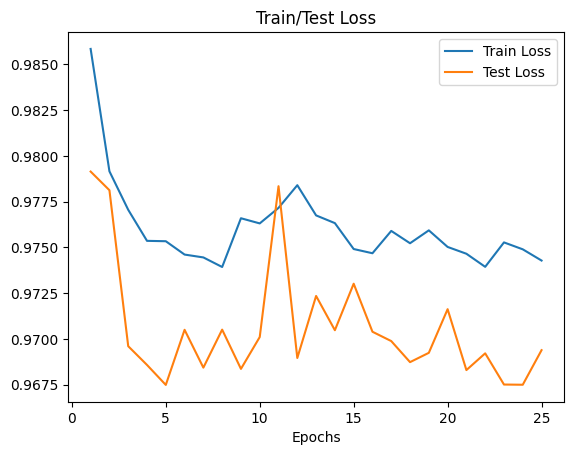

In [43]:
plt.plot(range(1, 1+NUM_EPOCHS), model_0_results["train_loss"], label="Train Loss")
plt.plot(range(1, 1+NUM_EPOCHS), model_0_results["test_loss"], label="Test Loss")
plt.title("Train/Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.show()

In [111]:
test_dataloader_pred = DataLoader(test_data, 
                             batch_size=1, 
                             shuffle=True, 
                             #num_workers=NUM_WORKERS,
                             )

test_sample_img, test_sample_target = next(iter(test_dataloader_pred))

test_sample_img = test_sample_img.to(device)
for key in test_sample_target.keys():
    test_sample_target[key] = test_sample_target[key].to(device)


test_sample_target['image_id']

tensor([[342]], device='cuda:0')

In [112]:
model_0.eval()
with torch.inference_mode():
    test_pred_output = model_0(test_sample_img)

test_pred_output

tensor([[  2.3562,  90.5286, 220.8131, 162.2442]], device='cuda:0')

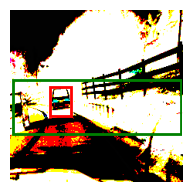

In [174]:
test_dataloader_pred = DataLoader(test_data, 
                             batch_size=1, 
                             shuffle=True, 
                             #num_workers=NUM_WORKERS,
                             )

test_sample_img, test_sample_target = next(iter(test_dataloader_pred))

test_sample_img = test_sample_img.to(device)
for key in test_sample_target.keys():
    test_sample_target[key] = test_sample_target[key].to(device)


idx = test_sample_target['image_id']
model_0.eval()
with torch.inference_mode():
    test_pred_output = model_0(test_sample_img).to('cpu')


test_data.show_with_box(index=idx, color='r', pred_box=True, bbox_pred=test_pred_output)